In [1]:
import numpy as np
# import torchviz
import wandb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import io
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from util import TokenMergeBuffer, TokenUnmergeBuffer, EarlyStopper
from models import AE
import x_lines_dataset

from types import SimpleNamespace

%load_ext autoreload
%autoreload 2

## Dataset

In [3]:
train_loader, val_loader = x_lines_dataset.get_x_lines_dataset(dataset_size=2000, num_pairs=2)

sample = next(iter(train_loader))
print(f"sample.shape: {sample.shape}")

sample.shape: torch.Size([64, 4, 4])


## Training

### Eval

In [25]:
@torch.no_grad()
def evaluate(model, val_loader, device, policy="softmax", max_depth=None):
    """
    Full validation pass for the merging Autoencoder.

    Args:
        model: AE model with lift/encode/decode.
        val_loader: DataLoader
        device: torch.device
        policy: merging policy ("argmin", "uniform", "softmax")
    """
    model.eval()
    total_val_loss = 0.0

    for batch in val_loader:
        raw_tokens = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)

        buf = TokenMergeBuffer(raw_tokens)

        # === MERGE LOOP ===
        while buf.n_active_tokens > 1 and (max_depth is None or buf.n_merge < max_depth):
            active = buf.get_active_tokens()
            B, N, D = active.shape
            pair_idx = torch.combinations(torch.arange(N, device=device))
            num_pairs = pair_idx.shape[0]

            t1 = active[:, pair_idx[:, 0], :]
            t2 = active[:, pair_idx[:, 1], :]

            t1 = t1.detach()
            t2 = t2.detach()

            t1_lifted = model.lift(t1)
            t2_lifted = model.lift(t2)

            x = torch.cat([t1_lifted, t2_lifted], dim=-1)
            # x_flat = x.reshape(B * num_pairs, -1)

            x_hat = model(x)

            t1_hat, t2_hat = torch.chunk(x_hat, 2, dim=-1)                    
            t1_hat_unlift = model.unlift(t1_hat) 
            t2_hat_unlift = model.unlift(t2_hat)  

            recon_loss = (
                (t1_hat_unlift - t1).pow(2).mean(dim=1) +
                (t2_hat_unlift - t2).pow(2).mean(dim=1)
            ) / 2.0

            # loss_per_pair = recon_loss.view(B, num_pairs)
            loss_per_pair = recon_loss

            # Deterministic policy by default (for stable validation)
            if policy == "argmin":
                chosen = loss_per_pair.argmin(dim=1)
            elif policy == "softmax":
                probs = torch.softmax(-loss_per_pair, dim=1)
                chosen = torch.multinomial(probs, 1).squeeze(1)
            elif policy == "uniform":
                chosen = torch.randint(0, num_pairs, (B,), device=device)
            else:
                raise ValueError(f"Unknown policy {policy}")

            local_t1_idx = pair_idx[chosen, 0]
            local_t2_idx = pair_idx[chosen, 1]

            chosen_t1 = active[torch.arange(B), local_t1_idx, :]
            chosen_t2 = active[torch.arange(B), local_t2_idx, :]
            chosen_t1 = model.lift(chosen_t1)
            chosen_t2 = model.lift(chosen_t2)
                
            chosen_x = torch.cat([chosen_t1, chosen_t2], dim=-1)

            merged_tokens = model.encode(chosen_x)
            merged_tokens = model.unlift(merged_tokens)
            buf.merge_batch(local_t1_idx, local_t2_idx, merged_tokens)

        # === UNMERGE LOOP ===
        buffer = buf.buffer
        merge_history = buf.get_merge_history()
        active_mask = buf.get_active_mask()
        n_original_tokens = raw_tokens.shape[1]

        unmerge_buf = TokenUnmergeBuffer(buffer=buffer,
                                            active_mask=active_mask,
                                            merges=merge_history,
                                            n_original=n_original_tokens)

        while not unmerge_buf.is_done():
            merged_token = unmerge_buf.get_next_to_unmerge()
            merged_token = model.lift(merged_token)
            pred = model.decode(merged_token)
            t1_pred, t2_pred = torch.chunk(pred, 2, dim=-1)
            t1_pred = model.unlift(t1_pred)
            t2_pred = model.unlift(t2_pred)
            unmerge_buf.step_unmerge(t1_pred, t2_pred)

        reconstructed = unmerge_buf.get_original_tokens()

        loss = (reconstructed - raw_tokens).pow(2).mean()

        total_val_loss += loss.item()

    return total_val_loss / len(val_loader)


### Visualisation

In [5]:
def plot_lines(tokens, ax=None, color="blue", label=None, linewidth=2):
    """
    tokens: (N, 4) – each row is [x1, y1, x2, y2]
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))

    tokens = tokens.cpu().numpy() if hasattr(tokens, "cpu") else tokens

    for (x1, y1, x2, y2) in tokens:
        ax.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth)

    if label:
        ax.plot([], [], color=color, label=label)

    ax.set_aspect("equal")
    return ax


def plot_line_comparison(original, reconstructed, title="Line Reconstruction", log_wandb=False):
    """
    original: (N, 4)
    reconstructed: (N, 4)
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    plot_lines(original, ax=ax, color="blue", label="Original")
    plot_lines(reconstructed, ax=ax, color="red", label="Reconstructed")

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")

    if log_wandb:
        import wandb
        wandb.log({"reconstruction_plot": wandb.Image(fig)})
    else:
        plt.show()

    plt.close(fig)


In [32]:
@torch.no_grad()
def visualise_reconstruction(model, val_loader, config, device, max_depth=None, log_wandb=False):

    raw_tokens = next(iter(val_loader)).to(device)   # shape (B, N, 4)
    buf = TokenMergeBuffer(raw_tokens)

    # === MERGE LOOP ===
    while buf.n_active_tokens > 1 and (max_depth is None or buf.n_merge < max_depth):
        active = buf.get_active_tokens()  # (B, N, D)
        B, N, D = active.shape

        pair_idx = torch.combinations(torch.arange(N, device=device))
        num_pairs = pair_idx.shape[0]

        # Build pairwise model inputs
        t1 = active[:, pair_idx[:, 0], :]
        t2 = active[:, pair_idx[:, 1], :]

        t1_lifted = model.lift(t1)
        t2_lifted = model.lift(t2)

        x = torch.cat([t1_lifted, t2_lifted], dim=-1)

        x_hat = model(x)

        t1_hat, t2_hat = torch.chunk(x_hat, 2, dim=-1)                    
        t1_hat_unlift = model.unlift(t1_hat) 
        t2_hat_unlift = model.unlift(t2_hat)  

        recon_loss = (
            (t1_hat_unlift - t1).pow(2).mean(dim=1) +
            (t2_hat_unlift - t2).pow(2).mean(dim=1)
        ) / 2.0

        # Sampling policy
        policy = config.sampling_policy
        if policy == "argmin":
            chosen = recon_loss.argmin(dim=1)
        elif policy == "uniform":
            chosen = torch.randint(0, num_pairs, (B,), device=device)
        elif policy == "softmax":
            probs = torch.softmax(-recon_loss, dim=1)
            chosen = torch.multinomial(probs, 1).squeeze(1)
        else:
            raise ValueError(f"Unknown sampling policy: {policy}")

        local_t1_idx = pair_idx[chosen, 0]
        local_t2_idx = pair_idx[chosen, 1]

        # merge tokens
        chosen_t1 = active[torch.arange(B), local_t1_idx, :]
        chosen_t2 = active[torch.arange(B), local_t2_idx, :]
        chosen_t1 = model.lift(chosen_t1)
        chosen_t2 = model.lift(chosen_t2)
            
        chosen_x = torch.cat([chosen_t1, chosen_t2], dim=-1)

        merged_tokens = model.encode(chosen_x)
        merged_tokens = model.unlift(merged_tokens)
        buf.merge_batch(local_t1_idx, local_t2_idx, merged_tokens)

    # === UNMERGE ===
    unmerge_buf = TokenUnmergeBuffer(
        buffer=buf.buffer,
        active_mask=buf.get_active_mask(),
        merges=buf.get_merge_history(),
        n_original=raw_tokens.shape[1]
    )

    while not unmerge_buf.is_done():
        merged_token = unmerge_buf.get_next_to_unmerge()
        merged_token = model.lift(merged_token)
        pred = model.decode(merged_token)
        t1_pred, t2_pred = torch.chunk(pred, 2, dim=-1)
        t1_pred = model.unlift(t1_pred)
        t2_pred = model.unlift(t2_pred)
        unmerge_buf.step_unmerge(t1_pred, t2_pred)

    reconstructed = unmerge_buf.get_original_tokens()

    # === RETURN THE FIRST SAMPLE FOR VISUALISATION ===
    return raw_tokens[0], reconstructed[0]


### Train

In [7]:
def get_merge_depth(curr_epoch, total_epochs, max_depth):
    progress = curr_epoch / total_epochs
    depth = int(progress * max_depth)
    if depth == 0:
        depth = 1
    return depth

In [ ]:
def train(
        model, 
        train_loader,
        val_loader,
        config,
        device,
        checkpoint_path=None,
        max_depth=None,
        ):
    
    model.to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    best_val_loss = float('inf')

    stopper = EarlyStopper(patience=20, min_delta=1e-4)

    wandb.init(
        project="merging-AE",
        config=config,
        name=config.model_name
    )

    for epoch in range(config.epochs):
        model.train()
        total_train_loss = 0.0

        for batch in train_loader:
            optimiser.zero_grad()

            raw_tokens = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)

            # === LIFT TOKENS ===
            buf = TokenMergeBuffer(raw_tokens)

            current_depth = get_merge_depth(epoch+1, config.epochs, config.max_depth)

            # # === MERGE LOOP ===
            # while buf.n_active_tokens > 1 and (max_depth is None or buf.n_merge < max_depth):
            while buf.n_active_tokens > 1 and buf.n_merge < current_depth:

                active = buf.get_active_tokens()  # (B, N, D)
                B, N, D = active.shape

                pair_idx = torch.combinations(torch.arange(N, device=device))
                num_pairs = pair_idx.shape[0]

                t1 = active[:, pair_idx[:, 0], :]
                t2 = active[:, pair_idx[:, 1], :]

                t1 = t1.detach()
                t2 = t2.detach()

                t1_lifted = model.lift(t1)
                t2_lifted = model.lift(t2)

                x = torch.cat([t1_lifted, t2_lifted], dim=-1)
                # x_flat = x.reshape(B * num_pairs, -1)

                x_hat = model(x)

                t1_hat, t2_hat = torch.chunk(x_hat, 2, dim=-1)                    
                t1_hat_unlift = model.unlift(t1_hat) 
                t2_hat_unlift = model.unlift(t2_hat)  

                recon_loss = (
                    (t1_hat_unlift - t1).pow(2).mean(dim=1) +
                    (t2_hat_unlift - t2).pow(2).mean(dim=1)
                ) / 2.0

                # loss_per_pair = recon_loss.view(B, num_pairs)
                loss_per_pair = recon_loss

                # === SELECTION POLICY ===
                policy = config.sampling_policy
                if policy == "argmin":
                    chosen = loss_per_pair.argmin(dim=1)
                elif policy == "uniform":
                    chosen = torch.randint(0, num_pairs, (B,), device=device)
                elif policy == "softmax":
                    probs = torch.softmax(-loss_per_pair, dim=1)
                    chosen = torch.multinomial(probs, 1).squeeze(1)
                else:
                    raise ValueError(f"Unknown sampling policy: {policy}")

                local_t1_idx = pair_idx[chosen, 0]
                local_t2_idx = pair_idx[chosen, 1]

                chosen_t1 = active[torch.arange(B), local_t1_idx, :]
                chosen_t2 = active[torch.arange(B), local_t2_idx, :]
                chosen_t1 = model.lift(chosen_t1)
                chosen_t2 = model.lift(chosen_t2)
                 
                chosen_x = torch.cat([chosen_t1, chosen_t2], dim=-1)

                merged_tokens = model.encode(chosen_x)
                merged_tokens = model.unlift(merged_tokens)
                buf.merge_batch(local_t1_idx, local_t2_idx, merged_tokens)
            

            # === UNMERGE LOOP ===
            buffer = buf.buffer
            merge_history = buf.get_merge_history()
            active_mask = buf.get_active_mask()
            n_original_tokens = raw_tokens.shape[1]

            unmerge_buf = TokenUnmergeBuffer(buffer=buffer,
                                             active_mask=active_mask,
                                             merges=merge_history,
                                             n_original=n_original_tokens)

            while not unmerge_buf.is_done():
                merged_token = unmerge_buf.get_next_to_unmerge()
                merged_token = model.lift(merged_token)
                pred = model.decode(merged_token)
                t1_pred, t2_pred = torch.chunk(pred, 2, dim=-1)
                t1_pred = model.unlift(t1_pred)
                t2_pred = model.unlift(t2_pred)
                unmerge_buf.step_unmerge(t1_pred, t2_pred)

            reconstructed = unmerge_buf.get_original_tokens()

            complete_recon_loss = (reconstructed - raw_tokens).pow(2).mean()

            # if epoch == 0 and total_train_loss == 0:  # only on first batch
            #     dot = torchviz.make_dot(complete_recon_loss,
            #                 params=dict(model.named_parameters()))
            #     dot.format = "png"
            #     dot.render("graph")   # Produces graph.png

            complete_recon_loss.backward()
            optimiser.step()

            total_train_loss += complete_recon_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # === VALIDATION ===
        val_loss = evaluate(model, val_loader, device, config.sampling_policy, max_depth)

        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "epoch": epoch,
            "merge_depth": current_depth,
            })


        # === SAVE BEST ===
        if checkpoint_path and val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path)

            orig, recon = visualise_reconstruction(model, val_loader, config, device)
            plot_line_comparison(orig, recon, log_wandb=True)
            
            # visualise_reconstruction(model, val_loader, config, device, max_depth=max_depth, log_wandb=True)
        
        if stopper.should_stop(val_loss):
            print(f"Early stopping at epoch {epoch}")
            break
        

    wandb.finish()

In [9]:
def train_AE_no_merges(
        model, 
        train_loader,
        val_loader,
        config,
        device,
        checkpoint_path=None,
        max_depth=None,   # ignored — kept for compatibility
    ):
    
    model.to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    best_val_loss = float('inf')
    stopper = EarlyStopper(patience=10, min_delta=1e-4)

    wandb.init(
        project="merging-AE",
        config=config,
        name=config.model_name
    )

    for epoch in range(config.epochs):
        model.train()
        total_train_loss = 0.0

        for batch in train_loader:
            optimiser.zero_grad()

            raw_tokens = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)

            # ==== STANDARD AUTOENCODER FORWARD ====
            lifted = model.lift(raw_tokens)              # (B, D)
            encoded = model.encode(torch.cat([lifted, lifted], dim=-1))  # fake merge for AE
            decoded = model.decode(encoded)
            t1, t2 = torch.chunk(decoded, 2, dim=-1)

            # average two reconstructions
            reconstructed = (t1 + t2) / 2
            reconstructed_unlifted = model.unlift(reconstructed)

            loss = (reconstructed_unlifted - raw_tokens).pow(2).mean()

            loss.backward()
            optimiser.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # ==== VALIDATION ====
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                raw_tokens = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)

                lifted = model.lift(raw_tokens)
                encoded = model.encode(torch.cat([lifted, lifted], dim=-1))
                decoded = model.decode(encoded)
                t1, t2 = torch.chunk(decoded, 2, dim=-1)
                reconstructed = (t1 + t2) / 2
                reconstructed_unlifted = model.unlift(reconstructed)

                val_loss = (reconstructed_unlifted - raw_tokens).pow(2).mean()
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # ==== LOGGING ====
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "epoch": epoch,
        })

        # ==== CHECKPOINT ====
        if checkpoint_path and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path)

            orig = next(iter(val_loader))
            # TODO: write proper func to vize
            recon = 0
            plot_line_comparison(orig, recon, log_wandb=True)

        # ==== EARLY STOPPING ====
        # if stopper.should_stop(avg_val_loss):
        #     print(f"Early stopping at epoch {epoch}")
        #     break

    wandb.finish()


### Main

In [22]:
token_dim = 4
latent_dim = 8
hidden_dim = 256
max_depth = 1

config = SimpleNamespace(
    epochs=1000,
    learning_rate=1e-3,
    sampling_policy="argmin",
    batch_size=64,
    device=device,
    model_name=f"AE-argmin-xlines-lr-{1e-3}-latent-{latent_dim}-no-merges",
    max_depth=max_depth,
    latent_dim=latent_dim,
    token_dim=token_dim,
    hidden_dim=hidden_dim,
)

model = AE(
    token_dim=token_dim,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim
    ).to(device)

train_AE_no_merges(model, train_loader, val_loader, config, device, checkpoint_path=f"./checkpoints/{config.model_name}.pth", max_depth=max_depth)

epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇█████
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▃▃▂▃▂▂▄▂▅▃▂▃▄▂▂▇▁▄▁▁▂▁▂▄▁▁▂▁▁▃▁▁▁▂▁
epoch,999
train_loss,1e-05
val_loss,1e-05


In [39]:
token_dim = 4
latent_dim = 8
hidden_dim = 64
max_depth = 1

config = SimpleNamespace(
    epochs=1000,
    learning_rate=1e-3,
    sampling_policy="softmax",
    batch_size=64,
    device=device,
    model_name=f"AE-softmax-xlines-lr-{1e-3}-latent-{latent_dim}-max-depth-{max_depth}-curriculum",
    max_depth=max_depth,
    latent_dim=latent_dim,
    token_dim=token_dim,
    hidden_dim=hidden_dim,
)

model = AE(
    token_dim=token_dim,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim
    ).to(device)

train(model, train_loader, val_loader, config, device, checkpoint_path=f"./checkpoints/{config.model_name}.pth", max_depth=max_depth)

../aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [0,0,0], thread: [34,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [0,0,0], thread: [35,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [0,0,0], thread: [36,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [0,0,0], thread: [39,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [0,0,0], thread: [41,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [0,0,0], thread: [42,0,0] Assertion `-sizes[i] <

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Baseline

In [11]:
def train_ae(
        model,
        train_loader,
        val_loader,
        config,
        device,
        checkpoint_path=None,
    ):
    
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.MSELoss()

    wandb.init(
        project="pair-AE",
        config=config,
        name=config.model_name
    )

    best_val_loss = float('inf')

    for epoch in range(config.epochs):
        model.train()
        total_train_loss = 0.0

        for batch in train_loader:
            optim.zero_grad()

            x = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)

            # ---- LIFT ----
            lifted = model.lift(x)                     # (B, N, latent_dim)

            # ---- FORM PAIRS ----
            t1 = lifted[:, :-1, :]                     # (B, N-1, D)
            t2 = lifted[:,  1:, :]                     # (B, N-1, D)
            pair_input = torch.cat([t1, t2], dim=-1)   # (B, N-1, 2D)

            B, NP, D2 = pair_input.shape
            flat_pairs = pair_input.reshape(B * NP, D2)

            # ---- AE FORWARD ----
            recon_flat = model(flat_pairs)             # (B*NP, 2D)
            recon_pairs = recon_flat.reshape(B, NP, D2)

            # ---- LOSS ----
            loss = criterion(recon_pairs, pair_input)

            # ---- BACKWARD ----
            loss.backward()
            optim.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        val_loss = evaluate_ae(model, val_loader, device)

        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "epoch": epoch,
        })

        if checkpoint_path and val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path)

            orig, recon = visualise_reconstruction(model, val_loader, config, device)
            plot_line_comparison(orig, recon, log_wandb=True)

    wandb.finish()


@torch.no_grad()
def evaluate_ae(model, loader, device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0

    for batch in loader:
        x = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)
        lifted = model.lift(x)

        t1 = lifted[:, :-1, :]
        t2 = lifted[:, 1:, :]
        pair_input = torch.cat([t1, t2], dim=-1)

        B, NP, D2 = pair_input.shape
        flat_pairs = pair_input.reshape(B * NP, D2)

        recon_flat = model(flat_pairs)
        recon_pairs = recon_flat.reshape(B, NP, D2)

        loss = criterion(recon_pairs, pair_input)
        total_loss += loss.item()

    return total_loss / len(loader)




token_dim = 4
latent_dim = 8
hidden_dim = 256
max_depth = 1

config = SimpleNamespace(
    epochs=1000,
    learning_rate=1e-3,
    sampling_policy="softmax",
    batch_size=64,
    device=device,
    model_name=f"AE-softmax-xlines-lr-{1e-3}-latent-{latent_dim}-max-depth-{max_depth}-curriculum-depth",
    max_depth=max_depth,
    latent_dim=latent_dim,
    token_dim=token_dim,
    hidden_dim=hidden_dim,
)

model = AE(
    token_dim=token_dim,
    latent_dim=latent_dim,
    hidden_dim=hidden_dim
    ).to(device)

train_ae(model, train_loader, val_loader, config, device, checkpoint_path=f"./checkpoints/{config.model_name}.pth")

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,999
train_loss,0.01832
val_loss,0.01416


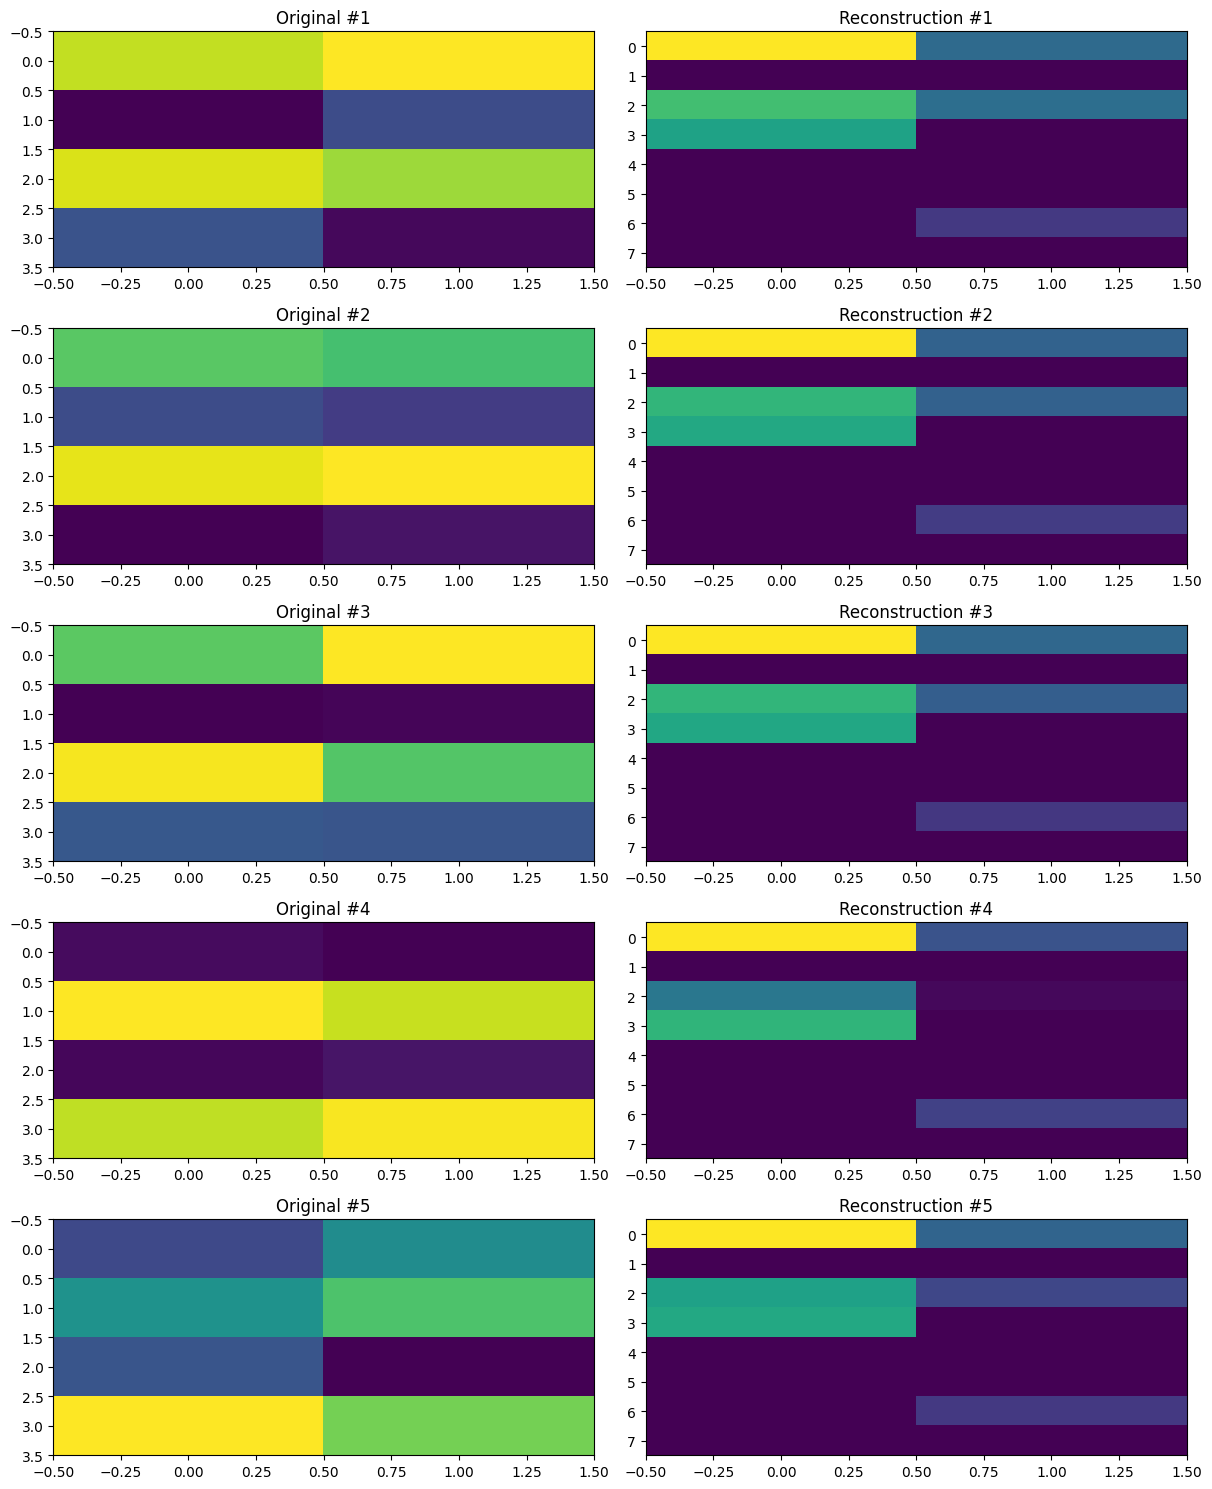

In [20]:
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def visualise_reconstruction_ae(model, loader, device, num_examples=5):
    """
    Visualizes original sequences and their AE reconstructions.

    Returns:
        orig_list: list of original sequences (num_examples, N, token_dim)
        recon_list: list of reconstructed sequences (num_examples, N, token_dim)
    """
    model.eval()
    batch = next(iter(loader))
    x = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)

    # ---- LIFT ----
    lifted = model.lift(x)  # (B, N, latent_dim)

    # ---- FORM PAIRS ----
    t1 = lifted[:, :-1, :]
    t2 = lifted[:, 1:, :]
    pair_input = torch.cat([t1, t2], dim=-1)  # (B, N-1, 2*latent_dim)

    B, NP, D2 = pair_input.shape
    flat_pairs = pair_input.reshape(B * NP, D2)

    # ---- AE FORWARD ----
    recon_flat = model(flat_pairs)
    recon_pairs = recon_flat.reshape(B, NP, D2)

    # ---- Reconstruct sequence (simple averaging trick) ----
    # Here we reconstruct lifted representation by averaging overlapping pairs
    recon_lifted = torch.zeros_like(lifted)
    recon_lifted[:, 1:-1, :] = 0.5 * (recon_pairs[:, :-1, :latent_dim] + recon_pairs[:, 1:, latent_dim:])
    recon_lifted[:, 0, :] = recon_pairs[:, 0, :latent_dim]
    recon_lifted[:, -1, :] = recon_pairs[:, -1, latent_dim:]

    # For plotting, take first `num_examples`
    orig_list = x[:num_examples].cpu().numpy()
    recon_list = recon_lifted[:num_examples].cpu().numpy()

    # ---- Plotting ----
    fig, axes = plt.subplots(num_examples, 2, figsize=(12, 3*num_examples))
    for i in range(num_examples):
        axes[i, 0].imshow(orig_list[i].T, aspect='auto', cmap='viridis')
        axes[i, 0].set_title(f'Original #{i+1}')
        axes[i, 1].imshow(recon_list[i].T, aspect='auto', cmap='viridis')
        axes[i, 1].set_title(f'Reconstruction #{i+1}')
    plt.tight_layout()
    plt.show()

    return orig_list, recon_list

_,_ = visualise_reconstruction_ae(model, val_loader, device, num_examples=5)

/tmp/ipykernel_838833/495118700.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


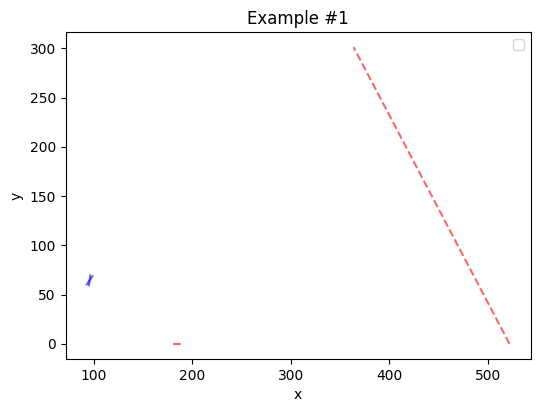

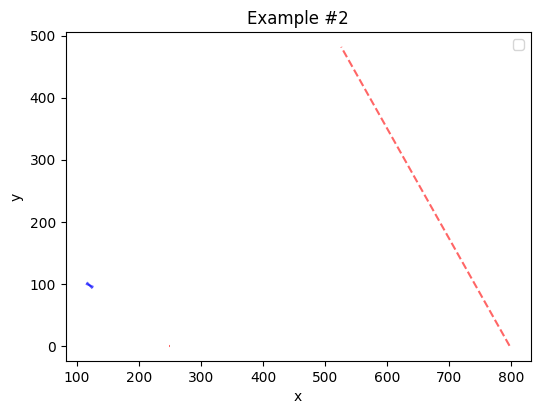

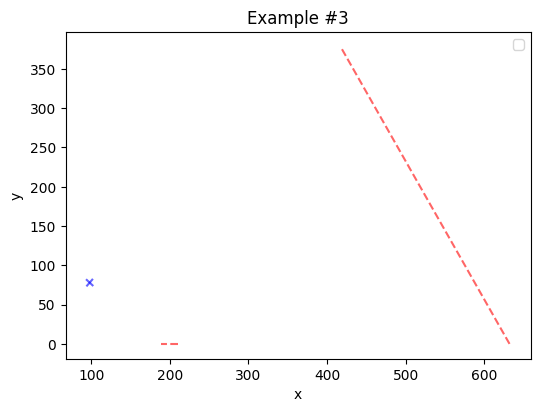

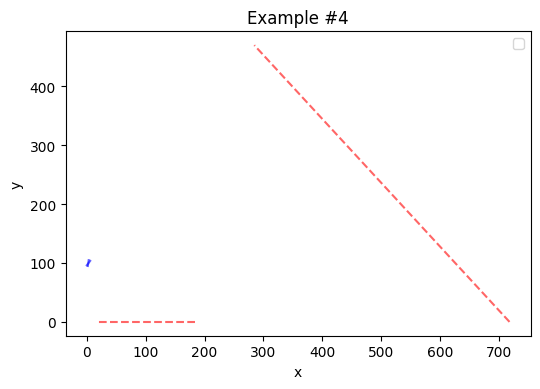

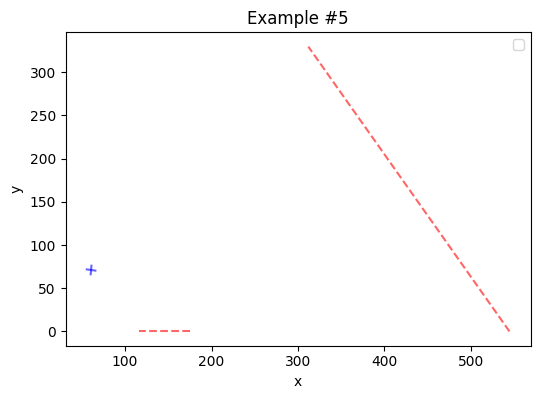

In [21]:
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def visualise_lines(model, loader, device, num_examples=5):
    """
    Visualizes original and reconstructed lines (x1,y1,x2,y2) from AE.
    """
    model.eval()
    batch = next(iter(loader))
    x = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)

    # ---- LIFT ----
    lifted = model.lift(x)  # (B, N, latent_dim)

    # ---- FORM PAIRS ----
    t1 = lifted[:, :-1, :]
    t2 = lifted[:, 1:, :]
    pair_input = torch.cat([t1, t2], dim=-1)  # (B, N-1, 2*latent_dim)

    B, NP, D2 = pair_input.shape
    flat_pairs = pair_input.reshape(B * NP, D2)

    # ---- AE FORWARD ----
    recon_flat = model(flat_pairs)
    recon_pairs = recon_flat.reshape(B, NP, D2)

    # ---- Reconstruct sequence (simple averaging trick) ----
    recon_lifted = torch.zeros_like(lifted)
    recon_lifted[:, 1:-1, :] = 0.5 * (recon_pairs[:, :-1, :latent_dim] + recon_pairs[:, 1:, latent_dim:])
    recon_lifted[:, 0, :] = recon_pairs[:, 0, :latent_dim]
    recon_lifted[:, -1, :] = recon_pairs[:, -1, latent_dim:]

    orig_list = x[:num_examples].cpu().numpy()         # (num_examples, N, 4)
    recon_list = recon_lifted[:num_examples].cpu().numpy()

    # ---- Plot lines ----
    for i in range(num_examples):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_title(f"Example #{i+1}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect('equal')

        # Plot original lines
        for line in orig_list[i]:
            x_vals = [line[0], line[2]]
            y_vals = [line[1], line[3]]
            ax.plot(x_vals, y_vals, color='blue', alpha=0.6, label='Original' if line is orig_list[i][0] else "")

        # Plot reconstructed lines
        for line in recon_list[i]:
            x_vals = [line[0], line[2]]
            y_vals = [line[1], line[3]]
            ax.plot(x_vals, y_vals, color='red', alpha=0.6, linestyle='--', label='Reconstruction' if line is recon_list[i][0] else "")

        ax.legend()
        plt.show()

    return orig_list, recon_list

_, _ = visualise_lines(model, val_loader, device, num_examples=5)

# Additional investigation of errors

In [19]:
with torch.no_grad():
    raw = next(iter(val_loader)).to(device)
    lifted = model.lift(raw)   # (B, N, latent_dim)
    B, N, D = lifted.shape

    idx = torch.randint(0, N, (B, 2), device=device)
    t1 = lifted[torch.arange(B), idx[:,0]]
    t2 = lifted[torch.arange(B), idx[:,1]]

    pair = torch.cat([t1, t2], dim=-1)  # (B, 2D)
    latent = model.encode(pair)

var = latent.var(dim=0).cpu()
print(var)


tensor([1.2365, 0.9962, 0.5962, 0.4416, 0.6435, 0.4715, 0.3122, 0.3183])


In [32]:
# pair = next(iter(val_loader))[0][:2,:].to(device)


# with torch.no_grad():
#     pair = model.lift(pair)
#     z = model.encode(pair)
#     print(z.abs().mean())


tensor([[-0.2197,  0.8183, -0.0635,  0.8129],
        [-0.1227,  0.7398, -0.1605,  0.8914],
        [-0.6965, -0.2955, -0.5497, -0.3490],
        [-0.6561, -0.3931, -0.5901, -0.2515],
        [ 0.6629, -0.3089,  0.5067, -0.3062],
        [ 0.6103, -0.2337,  0.5594, -0.3814],
        [-0.2868,  0.1396, -0.3428,  0.2855],
        [-0.2625,  0.1545, -0.3671,  0.2706]], device='cuda:0') tensor([[ 0.4061,  0.1512, -0.0692,  0.0949],
        [ 0.1023,  0.1171, -0.1046,  0.0805],
        [ 0.1447,  0.0897, -0.1044,  0.0994],
        [ 0.1800,  0.0415, -0.1685,  0.1615],
        [-0.1558,  0.2127,  0.1870, -0.0285],
        [-0.0856,  0.0938, -0.0655,  0.0209],
        [ 0.4481,  0.0086, -0.6607,  0.4811],
        [ 0.1073,  0.2934, -1.0384,  0.8414]], device='cuda:0')


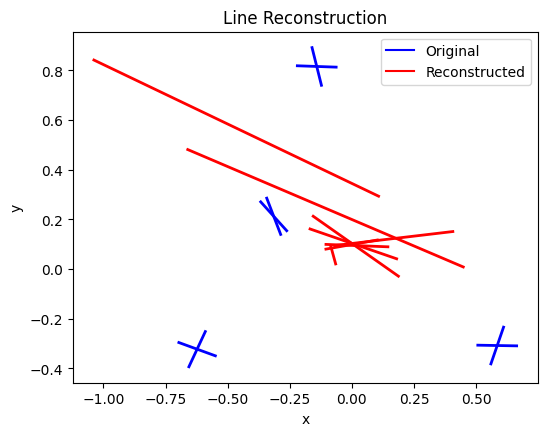

In [17]:
orig, recon = visualise_reconstruction(model, val_loader, config, device, index=63)
print(orig, recon)
plot_line_comparison(orig, recon)